# Lab:  Nonlinear Least Squares for Modeling Materials

Nonlinear least squares (NLLS) is a widely-used method for modeling data.  In NLLS, we wish to fit a model of the form,

     yhat = g(x,w)
     
where `w` is a vector of paramters and `x` is the vector of predictors.  We find `w` by minimizing a least-squares function 

     $$ f(w) = \sum_i (y_i - g(x_i,w))^2$$
     
where the summation is over training samples `(x_i,y_i)`.  This is similar to linear least-squares, but the function `g(x,w)` may not be linear in `w`.  In general, this optimization has no closed-form expression.  So numerical optimization must be used.  

In this lab, we will implement gradient descent on NLLS in a problem of physical modeling of materials.  Specifically, we will estimate parameters for expansion of copper as a function of temperature using a real dataset.  In doing this lab, you will learn to:
* Set up a nonlinear least squares as an unconstrained optimization function
* Compute initial parameter estimates for a simple rational model
* Compute the gradients of the least squares objective
* Implement gradient descent for minimizing the objective
* Implement momentum gradient descent
* Visualize the convergence of the algorithm

We first import some key packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data

The NIST agency has an excellent [nonlinear regression website](https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml) that has several datasets for nonlinear regression problems.  In this lab, we will use the data from a NIST study involving the thermal expansion of copper. The response variable is the coefficient of thermal expansion, and the predictor variable is temperature in degrees kelvin.  

> Hahn, T., NIST (1979), Copper Thermal Expansion Study.  (unpublished}

You can download the data as follows.

In [2]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['y0','x0','dummy'])
df.head()

,y0,x0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


Extract the `x0` and `y0` into arrays.  Rescale, `x0` and `y0` to values between `0` and `1` by dividing `x0` and `y0` by the maximum value.  Store the scaled values in vectors `x` and `y`.  The rescaling will help with the conditioning of the fitting.  Plot, `y` vs. `x`. 

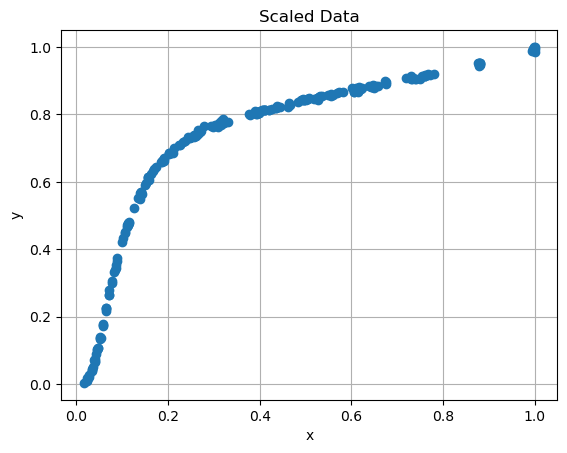

In [3]:
# TODO 1

x0 = df.x0
y0 = df.y0
x = x0/np.max(x0)
y = y0/np.max(y0)
plt.plot(x, y, 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scaled Data')
plt.grid()
plt.show()

To make the problem a little more challenging, we will add some noise.  Add random Gaussian noise with mean 0 and std. dev = 0.02 to `y`.  Store the noisy results in `yn`. You can use the `np.random.normal()` function to add Gaussian noise. Plot `yn` vs. `x`.

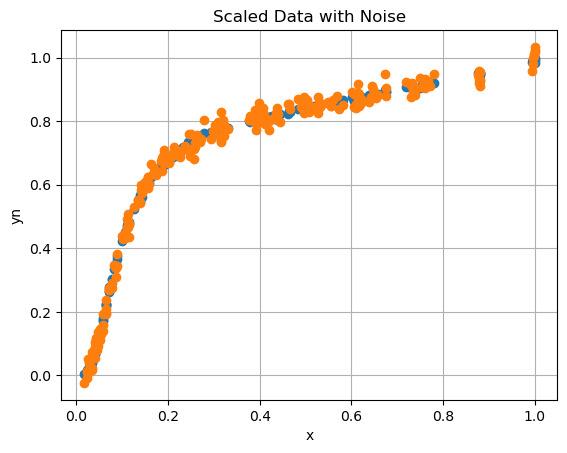

In [4]:
# TODO 2
yn = y + np.random.normal(0,0.02,len(y))

plt.plot(x, y, 'o')
plt.plot(x, yn, 'o')
plt.xlabel('x')
plt.ylabel('yn')
plt.title('Scaled Data with Noise')
plt.grid()
plt.show()

Split the data `(x,yn)` into training and test.  Let `xtr,ytr` be training data and `xts,yts` be the test data.  You can use the `train_test_split` function.  Set `test_size=0.33` so that 1/3 of the samples are held out for test.

In [5]:
from sklearn.model_selection import train_test_split

# TODO 3
xtr, xts, ytr, yts = train_test_split(x, yn, test_size=0.33)

## Initial Fit for a Rational Model

The [NIST website](https://www.itl.nist.gov/div898/strd/nls/data/hahn1.shtml) suggests using a *rational* model of the form,

      $$ yhat = \frac{(a[0] + a[1]*x + ... + a[d]*x^d)}{(1 + b[0]*x + ... + b[d-1]*x^d)} $$
      
with `d=3`.  The model parameters are $ w = [a[0],...,a[d],b[0],...,b[d-1]] $ so there are `2d+1` parameters total.    Complete the function below that takes vectors `w` and `x` and predicts a set of values `yhat` using the above model.
   

In [6]:
def predict(w,x):
    
    # Get the length
    d = (len(w)-1)//2
    
    # TODO 4.  Extract a and b from w
    a = w[:d+1]
    b = w[d+1:]
    
    # TODO 5.  Compute yhat.  You may use the np.polyval function
    # But, remember you must flip the order the a and b
    
    yhat = np.polyval(a[::-1], x) / (1+x * np.polyval(b[::-1], x))
    return yhat

When we fit with a nonlinear model, most methods only get convergence to a local minima.  So, you need a good initial condition.  For a rational model, one way to get is to realize that if:


    y ~= (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
    
Then:

    y ~= a[0] + a[1]*x + ... + a[d]*x^d - b[0]*x*y + ... - b[d-1]*x^d*y.
    
So, we can solve for the the parameters `w = [a,b]` from linear regression of the predictors,

    Z[i,:] = [ x[i], ... , x[i]**d, y[i]*x[i], ... , y[i}*x[i]**d ] 

In [7]:
d = 3

d_range = np.arange(1, d + 1)

# TODO 6.  Create the transformed feature matrix
a_param = np.column_stack([xtr ** p for p in d_range])
b_param = np.column_stack([-ytr * (xtr ** p) for p in d_range])
Z = np.hstack((a_param, b_param))


# TODO 7.  Fit with parameters with linear regression
print(Z.shape)
print(ytr.shape)
regr = LinearRegression()
regr.fit(Z, ytr)

# TODO 8
# Extract the parameters from regr.coef_ and regr.intercept_ and store the parameter vector in winit
winit = np.hstack((regr.intercept_, regr.coef_))

(158, 6)
(158,)


Now plot the predicted values of the `yhat` vs. `x` using your estimated parameter `winit` for 1000 values `x` in `[0,1]`.  On the same plot, plot `yts` vs. `xts`.  You will see that you get a horrible fit.

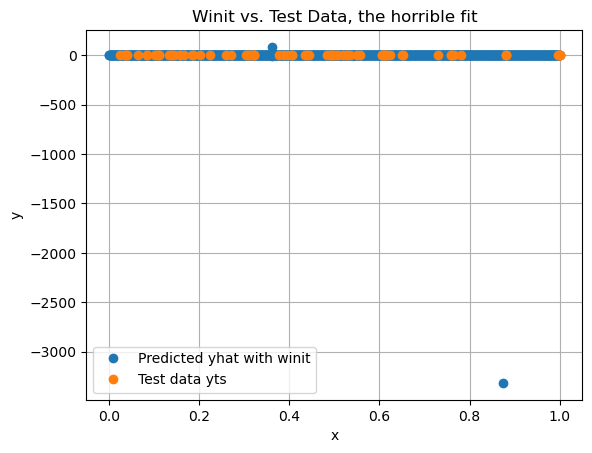

In [8]:
# TODO 9
xp = np.linspace(0, 1, 1000)
yhat = predict(winit, xp)
plt.plot(xp, yhat, 'o', label='Predicted yhat with winit')
plt.plot(xts, yts, 'o', label='Test data yts')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Winit vs. Test Data, the horrible fit')
plt.legend()
plt.grid()
plt.show()

The reason the previous fit is poor is that the denominator in `yhat` goes close to zero.   To avoid this problem, we can use Ridge regression, to try to keep the parameters close to zero.  Re-run the fit above with `Ridge` with `alpha = 1e-3`. You should see you get a reasonable, but not perfect fit.

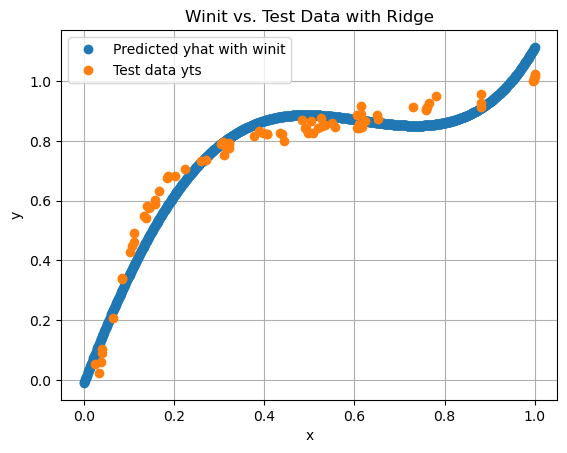

In [9]:
# TODO 10.  Fit with parameters with linear regression
regr = Ridge(alpha=1e-3)
regr.fit(Z, ytr)

# TODO 11
# Extract the parameters from regr.coef_ and regr.intercept_
winit = np.hstack((regr.intercept_, regr.coef_))

# TODO 12
# Plot the results as above.
xp = np.linspace(0, 1, 1000)
yhat = predict(winit, xp)
plt.plot(xp, yhat, 'o', label='Predicted yhat with winit')
plt.plot(xts, yts, 'o', label='Test data yts')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Winit vs. Test Data with Ridge')
plt.legend()
plt.grid()
plt.show()

## Creating a Loss Function

We can now use gradient descent to improve our initial estimate.  Complete the following function to compute

    f(w) = 0.5*\sum_i (y[i] - yhat[i])^2
    
and `fgrad`, the gradient of `f(w)`.

In [10]:
def feval(w,x,y):
        
    
    # TODO 13.  Parse w
    d = (len(w) - 1) // 2
    a = w[:d + 1]
    b = w[d + 1:]
    
    # TODO 14.  Znum[i,j] = x[i]**j
    j = np.arange(d)
    Znum = np.column_stack([x**j for j in range(d+1)])

    # TODO 15.  Zden[i,j] = x[i]**(j+1)
    j2 = np.arange(1, d) #todo test
    Zden = np.column_stack([x**(j+1) for j in range(1, d+1)])
    
    # TODO 16.  Compute yhat 
    # Compute the numerator and denominator
    
    numerator = Znum.dot(a)
    denominator = 1 + Zden.dot(b)
    yhat = numerator / denominator
    
    # TODO 17.  Compute loss
    f = 0.5 * np.sum((y - yhat) ** 2)
    
    # TODO 18.  Compute gradients
    error = y - yhat
    
    # expand dims to avoid ValueError: Multi-dimensional indexing (e.g. obj[:, None]) is no longer supported. Convert to a numpy array before indexing instead. 
    error_exp = np.expand_dims(error, axis=1)
    denominator_exp = np.expand_dims(denominator, axis=1)

    
    grad_a = -np.sum((error_exp * Znum) / denominator_exp, axis=0)
    grad_b = np.sum((error_exp * yhat[:, np.newaxis] * Zden) / denominator_exp, axis=0)
    
    fgrad = np.concatenate((grad_a, grad_b))
    
    return f, fgrad


Test the gradient function:
* Take `w0=winit` and compute `f0,fgrad0 = feval(w0,xtr,ytr)`
* Take `w1` very close to `w0` and compute `f1,fgrad1 = feval(w1,xtr,ytr)`
* Verify that `f1-f0` is close to the predicted value based on the gradient.

In [11]:
# TODO 19
w0 = winit

f0, fgrad0 = feval(w0, xtr, ytr)


# Take `w1` very close to `w0`
epsilon = 1e-6
w1 = w0 + epsilon * np.random.randn(len(w0))

f1, fgrad1 = feval(w1, xtr, ytr)

predicted_change = np.dot(fgrad0, w1 - w0)
actual_change = f1 - f0

print(f"Predicted change: {predicted_change:12.4e}")
print(f"Actual change: {actual_change:12.4e}")
print(f"Difference: {abs(predicted_change - actual_change)}")

Predicted change:   1.5094e-05
Actual change:   1.5095e-05
Difference: 3.298535083887512e-10


## Implement gradient descent

We will now try to minimize the loss function with gradient descent.  Using the function `feval` defined above, implement gradient descent.  Run gradient descent with a step size of `alpha=1e-6` starting at `w=winit`.  Run it for `nit=10000` iterations.  Compute `fgd[it]`= the objective function on iteration `it`.  Plot `fgd[it]` vs. `it`.  

You should see that the training loss decreases, but it still hasn't converged after 10000 iterations.

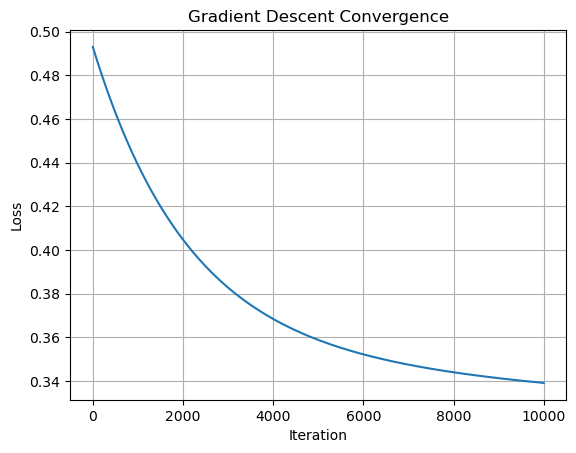

In [12]:
# TODO 20
w = winit
nit = 10000
fgd = np.zeros(nit)
step = 1e-6

for i in range(nit):
    f, fgrad = feval(w, xtr, ytr)
    
    fgd[i] = f
    
    w = w - step * fgrad
    
plt.plot(fgd)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Gradient Descent Convergence')
plt.grid()
plt.show()


Now, try to get a faster convergence with adaptive step-size using the Armijo rule. Implement the gradient descent with adaptive step size.  Let `fadapt[it]` be the loss function on iteration `it`.  Plot `fadapt[it]` and `fgd[it]` vs. `it` on the same graph.  You should see a slight improvement, but not much.

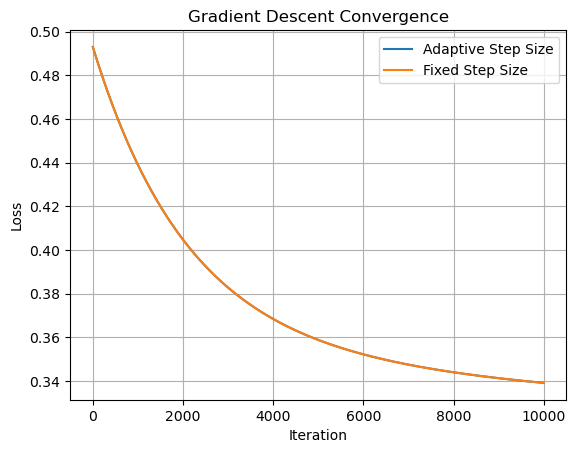

In [13]:
# TODO 21
w = winit
nit = 10000
fadapt = np.zeros(nit)
step = 1e-6  # Initial step

beta = 0.5 # step size
sigma = 1e-4 # Armijo param

for i in range(nit):
    f, fgrad = feval(w, xtr, ytr)
    
    fadapt[i] = f
    
    step_adapt = step
    while True:
        w_new = w - step_adapt * fgrad
        f_new, _ = feval(w_new, xtr, ytr)
        if f_new <= f - sigma * step_adapt * np.dot(fgrad, fgrad):
            break
        step_adapt *= beta
    
    w = w_new
    
plt.plot(fadapt, label='Adaptive Step Size')
plt.plot(fgd, label='Fixed Step Size')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Gradient Descent Convergence')
plt.legend()
plt.grid()
plt.show()

Using the final estimate for `w` from the adaptive step-size plot the predicted values of the `yhat` vs. `x` usfor 1000 values `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the initial parameter `w=winit`.  Also, plot `yts` vs. `xts`.  You should see that gradient descent was able to improve the estimat slightly, although the initial estimate was not too bad.

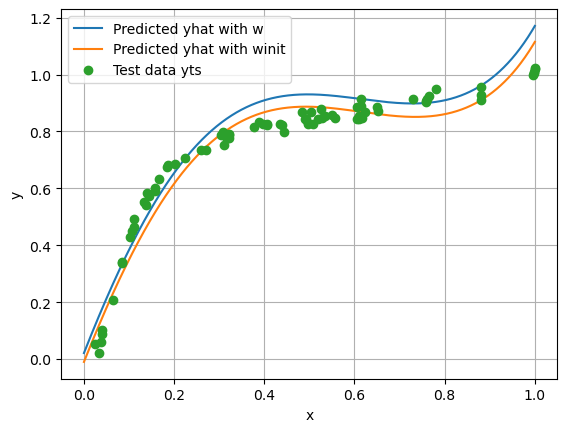

In [14]:
# TODO 22
xp = np.linspace(0, 1, 1000)

yhat = predict(w, xp)
yhat_init = predict(winit, xp)

plt.plot(xp, yhat, label='Predicted yhat with w')
plt.plot(xp, yhat_init, label='Predicted yhat with winit')
plt.plot(xts, yts, 'o', label='Test data yts')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

## Momentum Gradient Descent

This section is bonus.

One way to improve gradient descent is to use *momentum*.  In momentum gradient descent, the update rule is:

    f, fgrad = feval(w,...)
    z = beta*z + fgrad
    w = w - step*z
    
This is similar to gradient descent, except that there is a second order term on the gradient.  Implement this algorithm with `beta = 0.99` and `step=1e-3`.   Compare the convergence of the loss function with gradient descent.  

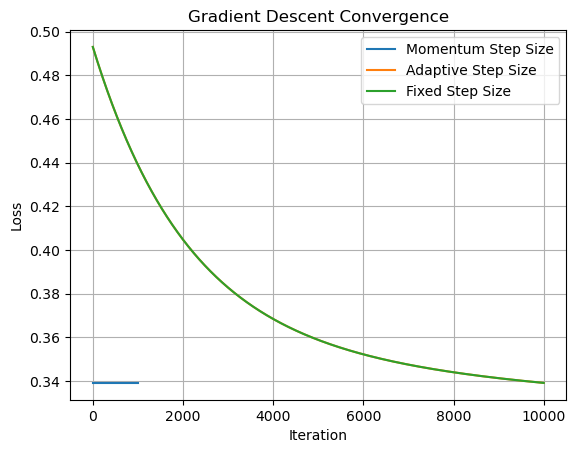

In [15]:
# TODO 23
nit = 1000
step = 1e-3
beta = 0.99

w_mome = winit 
fmome = np.zeros(nit)
z = np.zeros(len(w))

for i in range(nit):
    f, fgrad = feval(w, xtr, ytr)
    
    fmome[i] = f
    
    z = beta * z + fgrad
    w_mome = w_mome - step * z
    


    
plt.plot(fmome, label='Momentum Step Size')
plt.plot(fadapt, label='Adaptive Step Size')
plt.plot(fgd, label='Fixed Step Size')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Gradient Descent Convergence')
plt.legend()
plt.grid()
plt.show()

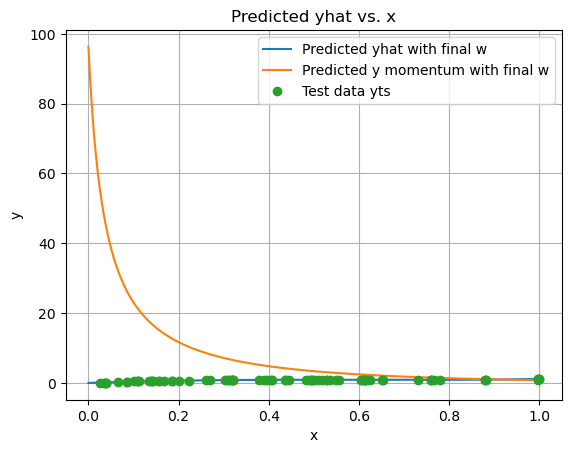

In [16]:
# TODO 24
# plot yhat vs. x


xp = np.linspace(0, 1, 1000)

yhat_final = predict(w, xp)
yhat_mome = predict(w_mome, xp)


plt.plot(xp, yhat_final, label='Predicted yhat with final w')
plt.plot(xp, yhat_mome, label='Predicted y momentum with final w')
plt.plot(xts, yts, 'o', label='Test data yts')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted yhat vs. x')
plt.legend()
plt.grid()
plt.show()


## Beyond This Lab
In this lab, we have just touched at some of the ideas in optimization.  There are several other important algorithms that you can explore:
* [Levenberg-Marquardt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) method for non-linear least squares
* Newton's method
* More difficult non-linear least squares problems.